In [283]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr, y_respiration,y_inspiration,y_expiration,groups = pickle.load(open('../../affect-recognition/data/tabular_data.p','rb'))
X_ppg = X_ppg.reshape(-1,512,1)
# X_ppg = np.array([RobustScaler().fit_transform(a) for a in X_ppg])
y_rr = 60000/(1000*y_rr)
print(X_ppg.shape)

(10842, 512, 1)


In [284]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tf
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=len(np.unique(groups)))
train,test = list(gkf.split(X_ppg,groups=groups))[1]
X_ppg_train,X_ppg_test = X_ppg[train],X_ppg[test]
X_qual_train,X_qual_test = X_qual[train],X_qual[test]
y_rr_train,y_rr_test = y_rr[train],y_rr[test]

In [306]:
def get_base_GRU(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Bidirectional(GRU(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(inputs)
    dense_layer = TimeDistributed(Dense(1,activation='relu'))(encoded)
    flattened = Flatten()(dense_layer)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(1,activation='relu')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder

def get_base_autoencoder(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Reshape((timesteps_ppg,))(inputs)
    encoded = Dense(timesteps_ppg//2,activation='linear')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation=0'selu')(encoded)
    encoded = Dense(timesteps_ppg//20,activation='linear')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation='selu')(encoded)
#     encoded = Dense(timesteps_ppg//2,activation='selu')(encoded)
    encoded = Dense(timesteps_ppg,activation='linear')(encoded)
#     encoded = Bidirectional(LSTM(first_dim,return_sequences=True,activation='tanh',go_backwards=True))(inputs)
#     encoded = TimeDistributed(Dense(1,activation='tanh'))(encoded)
#     flattened = Flatten()(dense_layer)
#     output = Dense(30,activation='sigmoid')(flattened)
#     output = Dense(timesteps_ppg,activation='sigmoid')(output)
    encoded = Reshape((timesteps_ppg, input_dim_ppg))(encoded)
#     output = Bidirectional(LSTM(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(output)
#     output = TimeDistributed(Dense(1,activation='sigmoid'))(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder


timesteps_ppg = 512
input_dim_ppg = 1
sequence_autoencoder = get_base_autoencoder(timesteps_ppg=timesteps_ppg,input_dim_ppg=input_dim_ppg,
                                    first_dim=60,optimizer='adam',loss='mse')
sequence_autoencoder.summary()

Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
reshape_76 (Reshape)         (None, 512)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_200 (Dense)            (None, 25)                6425      
_________________________________________________________________
dense_201 (Dense)            (None, 512)               13312     
_________________________________________________________________
reshape_77 (Reshape)         (None, 512, 1)            0         
Total params: 151,065
Trainable params: 151,065
Non-trainable params: 0
____________________________________________________

In [307]:
filepath = '../../affect-recognition/data/autoencoder.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_ppg_train, X_ppg_train,
                epochs=400,
                batch_size=200,
                shuffle=True,
                validation_split=.2,callbacks=callbacks_list)

Train on 8025 samples, validate on 2007 samples
Epoch 1/400
8025/8025 [==============================] - 0s 46us/step - loss: 3477.2949 - val_loss: 2787.5522

Epoch 00001: val_loss improved from inf to 2787.55216, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 2/400
8025/8025 [==============================] - 0s 41us/step - loss: 2195.7674 - val_loss: 1758.2888

Epoch 00002: val_loss improved from 2787.55216 to 1758.28882, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 3/400
8025/8025 [==============================] - 0s 41us/step - loss: 1434.5737 - val_loss: 1213.1741

Epoch 00003: val_loss improved from 1758.28882 to 1213.17409, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 4/400
8025/8025 [==============================] - 0s 41us/step - loss: 1066.3767 - val_loss: 942.9805

Epoch 00004: val_loss improved from 1213.17409 to 942.98052, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 5/400
8025/8025 [==

8025/8025 [==============================] - 0s 41us/step - loss: 498.2885 - val_loss: 500.2920

Epoch 00042: val_loss improved from 500.95394 to 500.29203, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 43/400
8025/8025 [==============================] - 0s 43us/step - loss: 497.5261 - val_loss: 499.7673

Epoch 00043: val_loss improved from 500.29203 to 499.76726, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 44/400
8025/8025 [==============================] - 0s 43us/step - loss: 497.8130 - val_loss: 500.1947

Epoch 00044: val_loss did not improve from 499.76726
Epoch 45/400
8025/8025 [==============================] - 0s 43us/step - loss: 496.4760 - val_loss: 500.5620

Epoch 00045: val_loss did not improve from 499.76726
Epoch 46/400
8025/8025 [==============================] - 0s 42us/step - loss: 499.9248 - val_loss: 504.3245

Epoch 00046: val_loss did not improve from 499.76726
Epoch 47/400
8025/8025 [==============================] - 0s 4

8025/8025 [==============================] - 0s 41us/step - loss: 498.9375 - val_loss: 503.9424

Epoch 00088: val_loss did not improve from 496.05069
Epoch 89/400
8025/8025 [==============================] - 0s 41us/step - loss: 501.5204 - val_loss: 501.3928

Epoch 00089: val_loss did not improve from 496.05069
Epoch 90/400
8025/8025 [==============================] - 0s 42us/step - loss: 497.1647 - val_loss: 499.1650

Epoch 00090: val_loss did not improve from 496.05069
Epoch 91/400
8025/8025 [==============================] - 0s 41us/step - loss: 503.4238 - val_loss: 502.1528

Epoch 00091: val_loss did not improve from 496.05069
Epoch 92/400
8025/8025 [==============================] - 0s 40us/step - loss: 496.8954 - val_loss: 499.6579

Epoch 00092: val_loss did not improve from 496.05069
Epoch 93/400
8025/8025 [==============================] - 0s 42us/step - loss: 500.3511 - val_loss: 502.4803

Epoch 00093: val_loss did not improve from 496.05069
Epoch 94/400
8025/8025 [===========

8025/8025 [==============================] - 0s 42us/step - loss: 494.8547 - val_loss: 496.5185

Epoch 00136: val_loss did not improve from 494.78788
Epoch 137/400
8025/8025 [==============================] - 0s 42us/step - loss: 497.3155 - val_loss: 499.4399

Epoch 00137: val_loss did not improve from 494.78788
Epoch 138/400
8025/8025 [==============================] - 0s 42us/step - loss: 499.9836 - val_loss: 500.2368

Epoch 00138: val_loss did not improve from 494.78788
Epoch 139/400
8025/8025 [==============================] - 0s 42us/step - loss: 497.6015 - val_loss: 498.8123

Epoch 00139: val_loss did not improve from 494.78788
Epoch 140/400
8025/8025 [==============================] - 0s 42us/step - loss: 494.8670 - val_loss: 497.3906

Epoch 00140: val_loss did not improve from 494.78788
Epoch 141/400
8025/8025 [==============================] - 0s 42us/step - loss: 494.6929 - val_loss: 495.6196

Epoch 00141: val_loss did not improve from 494.78788
Epoch 142/400
8025/8025 [=====

In [308]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [309]:
X_ppg_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


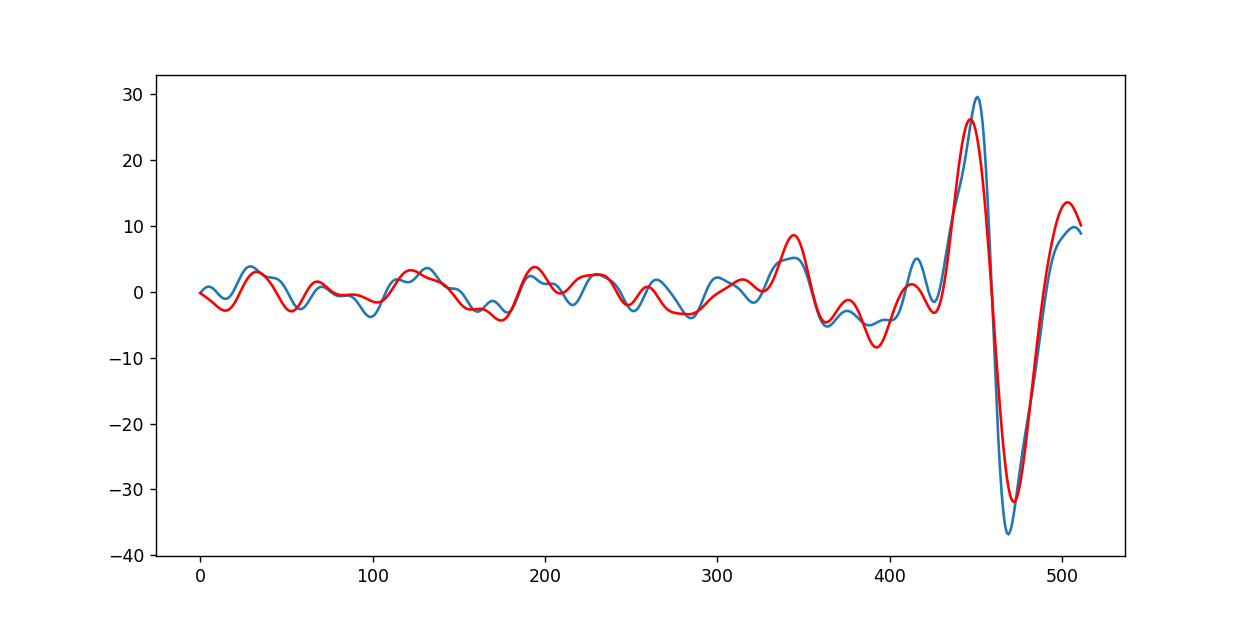

In [329]:
plt.figure(figsize=(10,5))
plt.plot(X_ppg_test[330])
plt.plot(X_ppg_pred[330],'r')
plt.show()

In [8]:
y_rr_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


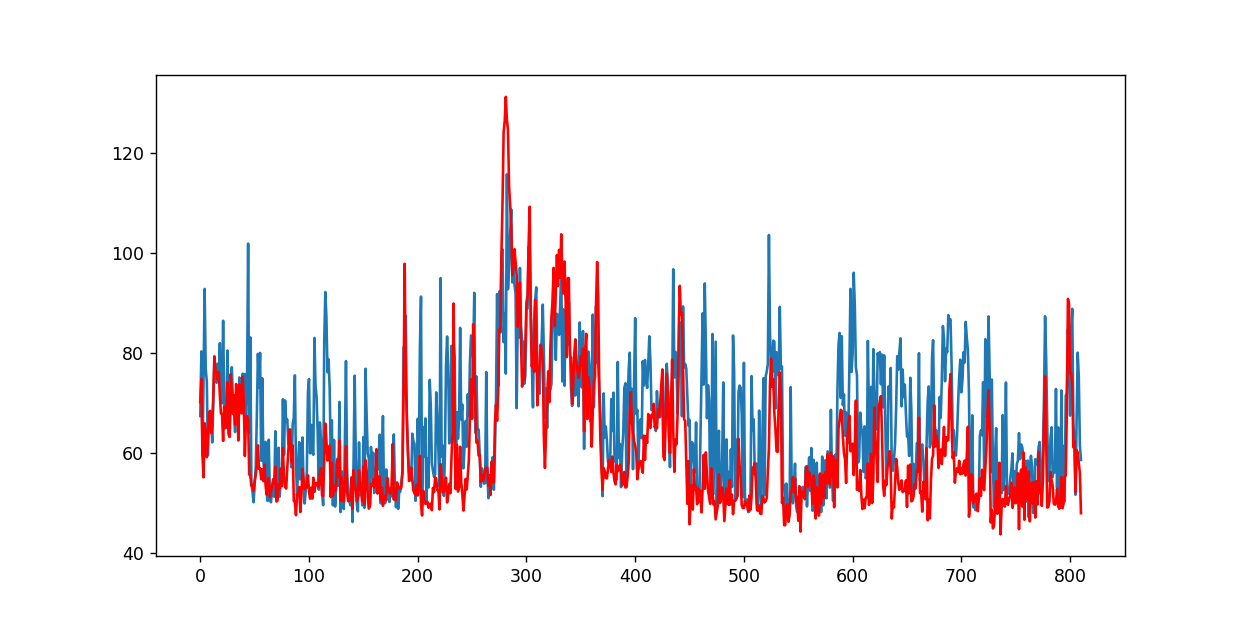

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_rr_pred)
plt.plot(y_rr_test,'r')

In [10]:
differences = np.abs(y_rr_pred-y_rr_test)

In [11]:
relative_powers = [np.mean(a[:,-1]) for a in X_qual_test]

<IPython.core.display.Javascript object>


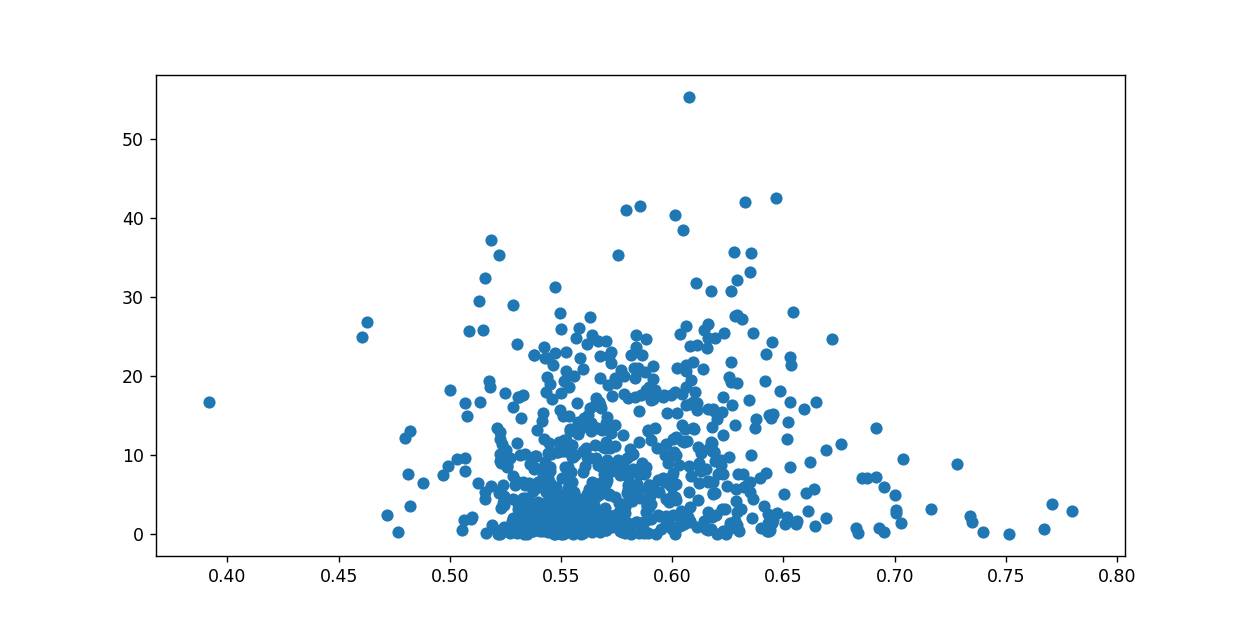

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(relative_powers,differences)
plt.show()

In [14]:
np.mean(differences)

8.563876893290832